# Hands on Machine Learning
Course: [Spring 2025 CS391L](https://utcs-ml-course.github.io/) at [UT Austin](https://www.utexas.edu/)

Instructor: [Prof. Inderjit Dhillon](https://www.cs.utexas.edu/~inderjit/)

Presented by: [Nilesh Gupta](https://nilesh2797.github.io/) (TA)

## Life of an ML Experiment
Machine Learning (ML) experiments are far more than just training a model—they encompass an entire lifecycle that includes problem formulation, data gathering, preprocessing, model building, training, evaluation, and continuous iteration. In this notebook, we’ll walk through a simplified version of this process using a binary image classification task.

Key Stages in the ML Experiment Lifecycle:

#### **Defining Problem**
Understand the problem you’re trying to solve. Define clear objectives and metrics that will be used to assess model performance.
#### **Defining Solution**
Concretizing the data representation, model, loss, and optimization choices. This stage involves mapping the problem to a concrete ML setup.

#### **Implementing Solution**
- **Setting up the ML environment**: Install the necessary libraries and set up the environment. This typically involves installing libraries, loading data, and preparing the notebook for experimentation.

- **Data Preparation**: Load and preprocess data. Data preprocessing is a crucial step that involves normalizing, augmenting, and splitting the data into training and validation sets.

- **Setting up Model and Optimization Process**: Design and implement a neural network architecture. Choose the right loss function, optimizer.

- **Training**: Set up the training loop that includes forward propagation, loss computation, backpropagation, and optimization. Effective training involves iterative improvements and fine-tuning of hyperparameters.

- **Evaluation & Metrics**: Assess the model using a validation/test set. Evaluating performance with metrics such as loss and accuracy provides insights into where improvements are needed.

- **Experiment Tracking & Iteration**: Document your findings, track experiments, and iterate on your design. Recording the results is crucial for reproducibility and helps guide subsequent refinements.

## Defining Problem

### **Demo problem**: classify images of dogs vs cats

### Key definitions of a problem
##### What is my input ($x$)?
- An image of a dog or a cat

##### What is my output ($y$)?
- A label indicating whether the image is a cat or a dog

##### How do I make a collection of such inputs and outputs a.k.a create my dataset ($\mathcal{D}$)?
- We can gather images of cats and dogs from various sources and manually label them (someone already did this for us - CIFAR10 dataset)

##### How do I measure success?
- Accuracy: the percentage of correctly classified images

### **Exercise problem**: build chatgpt?
<!-- ![](https://us1.discourse-cdn.com/openai1/original/3X/2/e/2e6fe61ecc55426e3b2b62dfd0b550ffd3b53d71.gif) -->
<img src="https://us1.discourse-cdn.com/openai1/original/3X/2/e/2e6fe61ecc55426e3b2b62dfd0b550ffd3b53d71.gif" width="400" height="400">

##### What is my input ($x$)?

##### What is my output ($y$)?

##### How do I make a collection of such inputs and outputs a.k.a create my dataset ($\mathcal{D}$)?

##### How do I measure success?

## Defining Solution

##### How do I represent my input ($x$) in numbers?
- Represent an image as a 3D tensor (channels, height, width) where each value represents the pixel intensity

##### How do I represent my output ($y$) in numbers?
- Represent the output as a single number (0 for cat, 1 for dog)

##### How do I map my input to my output a.k.a what is my model ($\mathcal{M}$)?
- Simple fully connected neural network with one hidden layer

##### How do I measure success in a differentiable way a.k.a what is my loss function ($\mathcal{L}$)?
> NOTE: usually we quantify the opposite of success i.e. the cost of making a mistake
- Binary cross-entropy loss

##### How do I train my model to minimize the loss a.k.a what is my optimizer ($\mathcal{O}$)?
- Use stochastic gradient descent (SGD) to minimize the loss

## Setting up the Environment

### Torch Imports
- `torch` and `torchvision` are the primary libraries used for building and training neural networks in PyTorch.
- `torch.nn` contains the building blocks for creating neural network models.
- `torch.nn.functional` provides functions that are used as building blocks in neural networks.
- `torch.optim` provides implementations of various optimization algorithms.
- `torch.utils.data` simplifies the data loading process for training and evaluation.
- `torchvision.datasets` and `torchvision.transforms` provide access to popular datasets and data transformations for computer vision tasks.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

### WandB

We use Weights & Biases (wandb) to log metrics and visualize results. Wandb is a tool that helps track experiments and collaborate with team members. It logs metrics, hyperparameters, and artifacts, and provides a dashboard to visualize and compare results.

API description: 
- `wandb.init()`: Initializes a new wandb run.
- `wandb.log()`: Logs metrics to the wandb dashboard.
- `wandb.watch()`: Logs gradients and parameters of the model to the wandb dashboard.
- `wandb.finish()`: Marks the end of the wandb run.

In [2]:
# Import wandb and initialize
import wandb

# Initialize wandb with a project name and configuration
wandb.init(
    project="hands_on_ml_demo",
    config={
        "learning_rate": 0.01,
        "epochs": 10,
        "batch_size": 32,
        "hidden_activation": "relu",
        "hidden_size": 128,
        "dataset": "CIFAR-10 (cats (0) vs dogs (1))",
        "model": "SimpleBinaryNet"
    }
)
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nilesh2797 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
print(*[f"{k}: {v}" for k, v in config.items()], sep="\n")

learning_rate: 0.01
epochs: 10
batch_size: 32
hidden_activation: relu
hidden_size: 128
dataset: CIFAR-10 (cats (0) vs dogs (1))
model: SimpleBinaryNet


## Data preparation

In [4]:
# Setup Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Setup Target Transformation (0 for cats, 1 for dogs)
target_transform = lambda x: 0 if x == 3 else 1

In [5]:
# Load and Filter CIFAR-10 Data for Binary Classification (Ships vs Planes)
train_dataset_full = datasets.CIFAR10(root='./data', train=True, transform=transform, target_transform=target_transform, download=True)
test_dataset_full = datasets.CIFAR10(root='./data', train=False, transform=transform, target_transform=target_transform, download=True)

train_indices = [i for i, target in enumerate(train_dataset_full.targets) if target in [3, 5]]
test_indices = [i for i, target in enumerate(test_dataset_full.targets) if target in [3, 5]]

train_dataset = Subset(train_dataset_full, train_indices)
test_dataset = Subset(test_dataset_full, test_indices)

# Create Validation Dataset
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

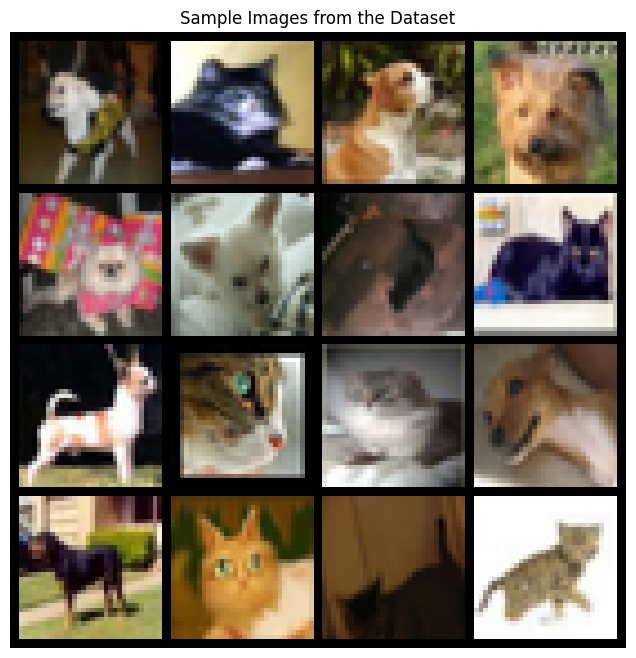

In [6]:
from torchvision.utils import make_grid

# Function to visualize sample images from the dataset
def visualize_samples(dataset, num_samples=16):
    # Get a subset of the dataset
    indices = torch.randperm(len(dataset))[:num_samples]
    samples = [dataset[i][0] for i in indices]
    
    # Create a grid of images
    grid = make_grid(samples, nrow=4, normalize=True)
    
    # Plot the grid
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Sample Images from the Dataset')
    plt.axis('off')
    plt.show()

# Visualize sample images from the training dataset
visualize_samples(train_dataset)

### Dataloader

`DataLoader` is used to load data in batches and provides various utilities for shuffling, batching, and loading data in parallel.
Important parameters:
- `dataset`: The dataset to load.
- `batch_size`: Number of samples in each batch.
- `shuffle`: If True, shuffles the data before creating batches.
- `num_workers`: Number of processes to use for data loading.

In [7]:
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

## Setting up Model, Loss, and Optimizer

In [8]:
# Define Simple Neural Network
class SimpleBinaryNet(nn.Module):
    def __init__(self, input_size=3*32*32, hidden_size=128, hidden_activation='sigmoid'):
        super(SimpleBinaryNet, self).__init__()
        self.w1 = nn.Parameter(torch.randn(input_size, hidden_size) / input_size**0.5) # Shape: (3*32*32) x hidden_size
        self.b1 = nn.Parameter(torch.zeros(hidden_size)) # Shape: hidden_size
        self.w2 = nn.Parameter(torch.randn(hidden_size, 1) / hidden_size**0.5) # Shape: hidden_size
        self.b2 = nn.Parameter(torch.zeros(1)) # Shape: 1
        self.hidden_activation_fn = F.sigmoid if hidden_activation == 'sigmoid' else F.relu if hidden_activation == 'relu' else ValueError("Unknown activation function")

    def forward(self, x):
        '''Forward pass of the network
        Args:
            x: Input tensor of shape (batch_size, 3*32*32)
        Returns:
            logits: Raw logits of shape (batch_size, 1)
        '''
        x = x.view(x.size(0), -1) # Flatten the image, shape: (batch_size, 3*32*32)
        z1 = torch.matmul(x, self.w1) + self.b1 # Shape: (batch_size, hidden_size)
        a1 = self.hidden_activation_fn(z1) # Shape: (batch_size, hidden_size)
        z2 = torch.matmul(a1, self.w2) + self.b2 # Shape: (batch_size, 1)
        return z2
    
class NNLinearBinaryNet(nn.Module):
    def __init__(self, input_size=3*32*32, hidden_size=128, hidden_activation='sigmoid'):
        super(NNLinearBinaryNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        self.hidden_activation_fn = F.sigmoid if hidden_activation == 'sigmoid' else F.relu if hidden_activation == 'relu' else ValueError("Unknown activation function")

    def forward(self, x):
        '''Forward pass of the network
        Args:
            x: Input tensor of shape (batch_size, 3*32*32)
        Returns:
            logits: Raw logits of shape (batch_size, 1)
        '''
        x = x.view(x.size(0), -1)  # Flatten the image, shape: (batch_size, 3*32*32)
        x = self.hidden_activation_fn(self.fc1(x)) # Shape: (batch_size, hidden_size)
        x = self.hidden_activation_fn(self.fc2(x))
        x = self.fc3(x)
        return x

if config.model == "SimpleBinaryNet":
    model = SimpleBinaryNet(input_size=3*32*32, hidden_size=config.hidden_size, hidden_activation=config.hidden_activation)
elif config.model == "NNLinearNet":
    model = NNLinearBinaryNet(input_size=3*32*32, hidden_size=config.hidden_size, hidden_activation=config.hidden_activation)
else:
    raise ValueError("Unknown model type")

# Use wandb.watch to log gradients and model parameters
wandb.watch(model, log="all", log_freq=100, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [9]:
# Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate)

In [10]:
sample_batch = next(iter(train_loader))

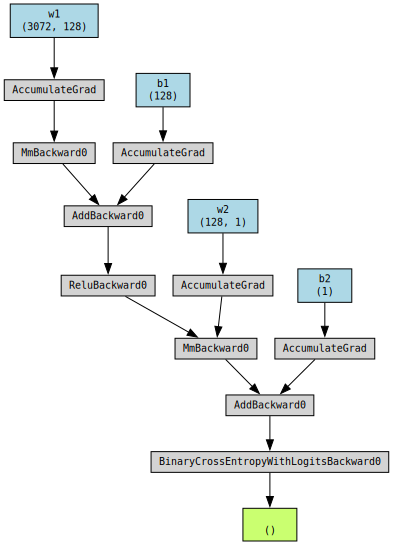

In [11]:
from torchviz import make_dot
pred = model(sample_batch[0])
loss = criterion(pred, sample_batch[1].float().view(-1, 1))
make_dot(loss, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

## Setting up Training and Evaluation Loops

In [12]:
from tqdm import tqdm

# Define Training and Evaluation Functions
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    running_num_batches = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch}', dynamic_ncols=True)
    for batch_idx, (data, target) in pbar:
        data, target = data.to(device), target.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_num_batches += 1
        # Log loss per batch
        wandb.log({"train_loss": loss.item(), "epoch": epoch, "batch": batch_idx})
        pbar.set_postfix({'mean loss': running_loss / running_num_batches})
    
    avg_loss = running_loss / len(train_loader)
    print(f'Average training loss for epoch {epoch}: {avg_loss:.6f}')
    return avg_loss

In [13]:
def evaluate(model, device, data_loader, criterion, epoch, split="val"):
    model.eval()
    test_loss = 0
    correct = 0
    sample_images = []  # To collect sample images and predictions
    sample_preds = []
    sample_targets = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            output = model(data)
            test_loss += criterion(output, target).item()
            preds = (torch.sigmoid(output) >= 0.5).to(target.dtype)  # threshold at 0.5
            correct += preds.eq(target.byte()).sum().item()

            # Save first batch sample predictions for visualization
            if batch_idx == 0:
                sample_images.append(data.cpu())
                sample_preds.append(preds.cpu())
                sample_targets.append(target.cpu())
    
    test_loss /= len(data_loader)
    accuracy = 100. * correct / len(data_loader.dataset)
    print(f'\n{split.capitalize()} set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n')
    
    # Log evaluation metrics to wandb
    wandb.log({f"{split}_loss": test_loss, f"{split}_accuracy": accuracy, "epoch": epoch})
    
    # Log sample predictions (showing first batch of test set)
    if sample_images:
        # Log a list of sample images with predictions and targets as captions
        wandb.log({
            f"{split}_sample_predictions": [wandb.Image(img, caption=f"Pred: {'Dog' if pred.item() else 'Cat'}, Gold: {'Dog' if target.item() else 'Cat'}")
                                   for img, pred, target in zip(sample_images[0], sample_preds[0], sample_targets[0])]
        })
    
    return test_loss, accuracy

## Training the Model

In [14]:
# Training and Evaluation Loop with wandb tracking
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = config.epochs

train_losses = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = evaluate(model, device, val_loader, criterion, epoch)
    train_loss, train_acc = evaluate(model, device, train_loader, criterion, epoch, split="train")
    
    wandb.log({"train_loss": train_loss, "train_accuracy": train_acc, "val_loss": val_loss, "val_accuracy": val_acc, "epoch": epoch})

Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 243.80it/s, mean loss=0.664]


Average training loss for epoch 1: 0.663668

Val set: Average loss: 0.6542, Accuracy: 60.50%


Train set: Average loss: 0.6381, Accuracy: 63.21%



Epoch 2: 100%|██████████| 250/250 [00:00<00:00, 287.84it/s, mean loss=0.638]


Average training loss for epoch 2: 0.637992

Val set: Average loss: 0.6510, Accuracy: 61.95%


Train set: Average loss: 0.6206, Accuracy: 65.42%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 296.58it/s, mean loss=0.624]


Average training loss for epoch 3: 0.624370

Val set: Average loss: 0.6471, Accuracy: 62.50%


Train set: Average loss: 0.6063, Accuracy: 66.96%



Epoch 4: 100%|██████████| 250/250 [00:00<00:00, 285.91it/s, mean loss=0.612]


Average training loss for epoch 4: 0.612083

Val set: Average loss: 0.6469, Accuracy: 62.25%


Train set: Average loss: 0.5976, Accuracy: 68.08%



Epoch 5: 100%|██████████| 250/250 [00:01<00:00, 230.08it/s, mean loss=0.603]


Average training loss for epoch 5: 0.603175

Val set: Average loss: 0.6406, Accuracy: 62.80%


Train set: Average loss: 0.5835, Accuracy: 69.89%



Epoch 6: 100%|██████████| 250/250 [00:00<00:00, 367.70it/s, mean loss=0.593]


Average training loss for epoch 6: 0.592636

Val set: Average loss: 0.6471, Accuracy: 62.85%


Train set: Average loss: 0.5771, Accuracy: 70.15%



Epoch 7: 100%|██████████| 250/250 [00:00<00:00, 348.59it/s, mean loss=0.582]


Average training loss for epoch 7: 0.582014

Val set: Average loss: 0.6437, Accuracy: 62.95%


Train set: Average loss: 0.5698, Accuracy: 71.16%



Epoch 8: 100%|██████████| 250/250 [00:00<00:00, 368.10it/s, mean loss=0.573]


Average training loss for epoch 8: 0.573100

Val set: Average loss: 0.6394, Accuracy: 63.50%


Train set: Average loss: 0.5544, Accuracy: 73.21%



Epoch 9: 100%|██████████| 250/250 [00:00<00:00, 369.93it/s, mean loss=0.562]


Average training loss for epoch 9: 0.562172

Val set: Average loss: 0.6506, Accuracy: 62.95%


Train set: Average loss: 0.5490, Accuracy: 73.10%



Epoch 10: 100%|██████████| 250/250 [00:00<00:00, 344.07it/s, mean loss=0.552]


Average training loss for epoch 10: 0.552380

Val set: Average loss: 0.6467, Accuracy: 63.25%


Train set: Average loss: 0.5327, Accuracy: 74.17%



## Evaluating the Model

In [15]:
test_loss, test_acc = evaluate(model, device, test_loader, criterion, epoch, split="test")
wandb.finish()


Test set: Average loss: 0.6390, Accuracy: 64.10%



batch,▂▇▇▃▃▄▄▆▆▂▄▄▆█▂▅▆▆▁▂▄██▅▆▁▃▄▅▇▁▂▅▅▅▂▂▃▅▆
epoch,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇█████
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▂▃▃▅▅▅▅▅▅▇▇▇▇▇▇██
train_loss,▇▄▆▅▃▇▆▄▅▃▅▆▄▅▂▄▅▅▄▄▆▃█▃▃▆▃▄▁▃▂▄▁▃▄▄▆▂▅▃
val_accuracy,▁▁▅▅▂▂▆▆▇▇██▅▅▇▇▆▆▇▇
val_loss,██▄▄▅▅▃▃▂▂▁▁▃▃▁▁▄▄▃▃
batch,249
epoch,10
test_accuracy,64.1


## Automatic Hyperparameter Sweep with wandb

Hyperparameter sweeps allow you to automatically explore different configurations to optimize your model's performance. In this section, we set up a sweep to tune key hyperparameters such as learning rate, batch size, and the size of the hidden layer. We use a Bayesian optimization approach to maximize the test accuracy.

The sweep will run multiple experiments, and wandb will aggregate the results so that you can easily compare and select the best configuration.

In [20]:
# Define the sweep configuration
sweep_configuration = {
    'method': 'grid',  # Bayesian optimization
    'metric': {
         'name': 'val_accuracy',
         'goal': 'maximize'
    },
    'parameters': {
         'learning_rate': {'values': [0.001, 0.0001, 0.01]},
         'batch_size': {'values': [32, 64, 128]},
         'hidden_size': {'values': [64, 128, 256]},
         'epochs': {'value': 3}  # keep epochs small for quick sweeps
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project="hands_on_ml_demo")
print("Sweep ID:", sweep_id)

Create sweep with ID: 1sn1nvxk
Sweep URL: https://wandb.ai/nilesh2797/hands_on_ml_demo/sweeps/1sn1nvxk
Sweep ID: 1sn1nvxk


In [21]:
def sweep_train():
    """Training function for hyperparameter sweep runs."""
    # Initialize wandb for this sweep run
    wandb.init()
    config = wandb.config
    
    # Set up data loaders using the hyperparameter batch size
    batch_size = config.batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model using the hyperparameter hidden_size
    model = SimpleBinaryNet(hidden_size=config.hidden_size)
    model.to(device)
    
    # Define loss function and optimizer with hyperparameter learning_rate
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate)
    
    # Run training for the specified number of epochs
    for epoch in range(1, config.epochs + 1):
         train_loss = train(model, device, train_loader, optimizer, criterion, epoch)
         val_loss, val_accuracy = evaluate(model, device, val_loader, criterion, epoch)
         
         # Log metrics for each epoch
         wandb.log({
             "epoch_train_loss": train_loss,
             "epoch_val_loss": val_loss,
             "val_accuracy": val_accuracy,
             "epoch": epoch
         })

    # Finish the run
    wandb.finish()

In [22]:
# Launch the sweep agent to run a specified number of runs
wandb.agent(sweep_id, function=sweep_train, count=None)

wandb: Agent Starting Run: 560ab4u8 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 250/250 [00:00<00:00, 302.01it/s, mean loss=0.707]


Average training loss for epoch 1: 0.707201

Val set: Average loss: 0.6967, Accuracy: 49.25%



Epoch 2: 100%|██████████| 250/250 [00:00<00:00, 324.50it/s, mean loss=0.69] 


Average training loss for epoch 2: 0.690431

Val set: Average loss: 0.6871, Accuracy: 54.60%



Epoch 3: 100%|██████████| 250/250 [00:01<00:00, 235.25it/s, mean loss=0.684]


Average training loss for epoch 3: 0.684309

Val set: Average loss: 0.6818, Accuracy: 57.10%



batch,▂▃▃▄▅▆▆▇▇▇▇▇█▁▂▃▄▄▅▆▇▇███▁▁▃▃▃▅▅▅▅▆▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▃▁
train_loss,▆██▆▅▁▃▁▇▂▂▅▆▄▂▄▃▄▃▃▅▃▂▄▃▄▁▄▃▄▃▂▃▃▃▅▂▄▂▄
val_accuracy,▁▁▆▆██
val_loss,█▃▁
batch,249
epoch,3
epoch_train_loss,0.68431
epoch_val_loss,0.68176


wandb: Agent Starting Run: ae5tv3br with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 250/250 [00:00<00:00, 294.21it/s, mean loss=0.7]  


Average training loss for epoch 1: 0.700002

Val set: Average loss: 0.7019, Accuracy: 49.30%



Epoch 2: 100%|██████████| 250/250 [00:00<00:00, 336.43it/s, mean loss=0.697]


Average training loss for epoch 2: 0.697356

Val set: Average loss: 0.6991, Accuracy: 49.60%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 312.14it/s, mean loss=0.695]


Average training loss for epoch 3: 0.695154

Val set: Average loss: 0.6967, Accuracy: 50.15%



batch,▁▂▃▃▃▄▅▆▆▇▇▇█▁▂▂▂▃▃▄▄▅▅▆▆▇██▁▁▂▃▄▄▄▅▆▇██
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅███████████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,▆▇▃▅▆▇▂█▃▅▄▅▆▇█▄▁▄█▆▆▆▁▇▃▄▅▅▅▄▆▃▁▆▅▆▄█▆▃
val_accuracy,▁▁▃▃██
val_loss,█▄▁
batch,249
epoch,3
epoch_train_loss,0.69515
epoch_val_loss,0.69671


wandb: Agent Starting Run: l2c9max2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 250/250 [00:00<00:00, 337.08it/s, mean loss=0.681]


Average training loss for epoch 1: 0.680718

Val set: Average loss: 0.6706, Accuracy: 59.40%



Epoch 2: 100%|██████████| 250/250 [00:00<00:00, 302.42it/s, mean loss=0.671]


Average training loss for epoch 2: 0.671256

Val set: Average loss: 0.6662, Accuracy: 59.50%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 356.63it/s, mean loss=0.667]


Average training loss for epoch 3: 0.667198

Val set: Average loss: 0.6635, Accuracy: 60.10%



batch,▁▁▂▂▃▄▄▅▆▆▇▇▇██▁▁▁▂▂▃▃▃▄▅▇▇▇█▂▂▃▄▄▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅██████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▄▁
train_loss,▆█▆▆▅█▆▅▆▆▇▇▃▆▅▅▅▄▄▅██▄▅▃█▁▂▇▄▇▅█▅▄▄▅▇▁▄
val_accuracy,▁▁▂▂██
val_loss,█▄▁
batch,249
epoch,3
epoch_train_loss,0.6672
epoch_val_loss,0.66352


wandb: Agent Starting Run: v502tr5o with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 250/250 [00:00<00:00, 295.53it/s, mean loss=0.696]


Average training loss for epoch 1: 0.695815

Val set: Average loss: 0.6864, Accuracy: 57.10%



Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 229.86it/s, mean loss=0.686]


Average training loss for epoch 2: 0.685905

Val set: Average loss: 0.6821, Accuracy: 58.45%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 310.32it/s, mean loss=0.682]


Average training loss for epoch 3: 0.682092

Val set: Average loss: 0.6789, Accuracy: 59.35%



batch,▁▁▂▃▃▇▁▂▂▃▃▄▅▅▅▆▆▇▇▁▁▁▁▂▂▃▄▄▄▄▆▆▆▆▆▇▇▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▄▁
train_loss,▆▄█▅▃▇▇▄▅▅▄▄▅▂▆▃▄▅▃▆▅▄▅▄▅▄▃▃▃▄▄▃▂▃▂▂▁▄▆▂
val_accuracy,▁▁▅▅██
val_loss,█▄▁
batch,249
epoch,3
epoch_train_loss,0.68209
epoch_val_loss,0.67888


wandb: Agent Starting Run: 25l6y941 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 250/250 [00:00<00:00, 308.08it/s, mean loss=0.694]


Average training loss for epoch 1: 0.694144

Val set: Average loss: 0.6940, Accuracy: 50.95%



Epoch 2: 100%|██████████| 250/250 [00:00<00:00, 280.28it/s, mean loss=0.693]


Average training loss for epoch 2: 0.692519

Val set: Average loss: 0.6929, Accuracy: 52.10%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 332.71it/s, mean loss=0.691]


Average training loss for epoch 3: 0.691221

Val set: Average loss: 0.6919, Accuracy: 51.95%



batch,▂▂▃▃▄▄▄▅▅▇█████▂▂▃▄▄▄▄▄▄▄▅▇▇▇█▁▂▂▃▃▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,▂▄▄▅▁█▅▅▃▆▅▆▆▆▆▅▆▇▆▄▅▄▆█▄▆▆▆▄▆▆▆▅▅▅▆▅▅▇▆
val_accuracy,▁▁██▇▇
val_loss,█▄▁
batch,249
epoch,3
epoch_train_loss,0.69122
epoch_val_loss,0.6919


wandb: Agent Starting Run: dj06tolz with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 220.67it/s, mean loss=0.68] 


Average training loss for epoch 1: 0.680385

Val set: Average loss: 0.6710, Accuracy: 59.30%



Epoch 2: 100%|██████████| 250/250 [00:00<00:00, 255.06it/s, mean loss=0.671]


Average training loss for epoch 2: 0.670618

Val set: Average loss: 0.6655, Accuracy: 59.75%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 282.68it/s, mean loss=0.667]


Average training loss for epoch 3: 0.666644

Val set: Average loss: 0.6645, Accuracy: 60.60%



batch,▁▁▁▁▂▂▃▃▃▃▄▄▅▆▆▇▇▇█▁▂▂▂▃▃▃▄▅▅▆▇▇▇▇▇██▁▂█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▂▁
train_loss,▅▆▇▆▇▄▃▅▅▅▄▅▄▇▁▆▅▃▃▄▅▁▇▄▃▄▅▄▆▄█▂▂▇▂▂▃▄█▄
val_accuracy,▁▁▃▃██
val_loss,█▂▁
batch,249
epoch,3
epoch_train_loss,0.66664
epoch_val_loss,0.66452


wandb: Agent Starting Run: yhu2aq0f with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 214.38it/s, mean loss=0.704]


Average training loss for epoch 1: 0.703914

Val set: Average loss: 0.6900, Accuracy: 52.00%



Epoch 2: 100%|██████████| 250/250 [00:00<00:00, 269.49it/s, mean loss=0.687]


Average training loss for epoch 2: 0.687089

Val set: Average loss: 0.6835, Accuracy: 55.95%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 310.40it/s, mean loss=0.682]


Average training loss for epoch 3: 0.682307

Val set: Average loss: 0.6793, Accuracy: 57.55%



batch,▁▂▂▃▄▅▅▅▆▇█▁▁▁▂▂▃▃▃▃▄▅▅▅▅▇▇█▁▁▄▅▅▆▇▇▇▇██
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▄▁
train_loss,█▄▄▅▃▃▄▃▄▃▃▄▂▄▂▂▃▂▃▄▃▂▃▃▁▂▂▃▃▄▂▃▃▂▃▃▅▄▄▁
val_accuracy,▁▁▆▆██
val_loss,█▄▁
batch,249
epoch,3
epoch_train_loss,0.68231
epoch_val_loss,0.67928


wandb: Agent Starting Run: 2g8ygd84 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 250/250 [00:00<00:00, 267.85it/s, mean loss=0.706]


Average training loss for epoch 1: 0.705731

Val set: Average loss: 0.7043, Accuracy: 49.20%



Epoch 2: 100%|██████████| 250/250 [00:00<00:00, 303.09it/s, mean loss=0.697]


Average training loss for epoch 2: 0.697079

Val set: Average loss: 0.6973, Accuracy: 49.10%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 299.53it/s, mean loss=0.693]


Average training loss for epoch 3: 0.692983

Val set: Average loss: 0.6936, Accuracy: 51.10%



batch,▁▂▂▂▃▄▄▅▆▇▇▇▁▁▁▂▄▅▅▆▆▇▇▇▇▁▁▁▂▂▂▂▃▃▃▅▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅██████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▃▁
train_loss,▆▆▂▅▅▆▃▅▄▇▇▅▆▆▁▇▂█▅▆▆▆▆▃▆▄▃▅▆▄▅▄▅▃▄▂▆▃▅▄
val_accuracy,▁▁▁▁██
val_loss,█▃▁
batch,249
epoch,3
epoch_train_loss,0.69298
epoch_val_loss,0.69361


wandb: Agent Starting Run: noft849u with config:
wandb: 	batch_size: 32
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 250/250 [00:00<00:00, 291.07it/s, mean loss=0.68] 


Average training loss for epoch 1: 0.679796

Val set: Average loss: 0.6701, Accuracy: 59.10%



Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 212.66it/s, mean loss=0.669]


Average training loss for epoch 2: 0.668984

Val set: Average loss: 0.6670, Accuracy: 59.15%



Epoch 3: 100%|██████████| 250/250 [00:00<00:00, 295.56it/s, mean loss=0.666]


Average training loss for epoch 3: 0.666017

Val set: Average loss: 0.6623, Accuracy: 60.65%



batch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▁▂▂▃▃▄▆▆▆▇▇█▂▂▃▃▄▅▅▆▆▇▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
epoch_train_loss,█▃▁
epoch_val_loss,█▅▁
train_loss,▆▄▅▅▃▃▄▁▆▇▇▅▆▄▇▁▃▁▅▅▂▄▅█▂▃▅▃▄▅▂▄▄▅▃▃▁▂▅▁
val_accuracy,▁▁▁▁██
val_loss,█▅▁
batch,249
epoch,3
epoch_train_loss,0.66602
epoch_val_loss,0.6623


wandb: Agent Starting Run: 8xilgzeo with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 148.54it/s, mean loss=0.755]


Average training loss for epoch 1: 0.754559

Val set: Average loss: 0.7158, Accuracy: 50.85%



Epoch 2: 100%|██████████| 125/125 [00:00<00:00, 180.99it/s, mean loss=0.71] 


Average training loss for epoch 2: 0.709623

Val set: Average loss: 0.6937, Accuracy: 51.40%



Epoch 3: 100%|██████████| 125/125 [00:00<00:00, 159.29it/s, mean loss=0.694]


Average training loss for epoch 3: 0.693613

Val set: Average loss: 0.6858, Accuracy: 53.50%



batch,▁▂▂▃▃▃▃▃▄▆▁▂▂▂▃▃▄▄▅▅▇▇▇▇██▁▁▂▂▅▅▅▅▆▇▇███
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅████████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▃▁
train_loss,▄█▆▄▂▁▃▇▃▆▂▆▄▃▄▁▄▄▃▂▃▁▃▁▃▂▂▃▂▃▃▁▂▂▁▂▂▃▂▂
val_accuracy,▁▁▂▂██
val_loss,█▃▁
batch,124
epoch,3
epoch_train_loss,0.69361
epoch_val_loss,0.68583


wandb: Agent Starting Run: q9gjw0yy with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 211.51it/s, mean loss=0.751]


Average training loss for epoch 1: 0.751483

Val set: Average loss: 0.7382, Accuracy: 50.85%



Epoch 2: 100%|██████████| 125/125 [00:00<00:00, 226.99it/s, mean loss=0.745]


Average training loss for epoch 2: 0.744822

Val set: Average loss: 0.7323, Accuracy: 50.85%



Epoch 3: 100%|██████████| 125/125 [00:00<00:00, 212.04it/s, mean loss=0.739]


Average training loss for epoch 3: 0.738824

Val set: Average loss: 0.7271, Accuracy: 50.85%



batch,▁▂▂▂▃▅▅▅▆▆▇▇▇▇█▃▃▄▄▄▅▅▆▆██▂▃▃▃▄▅▅▅▅▅▆███
epoch,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,█▄▇▅▆▅█▁▅▇▅▁▃▆▅▄▃▇▃█▃▇▆▅▅▁▅▇▅▅▆▄▆▄▄▆▅▄▄▁
val_accuracy,▁▁▁▁▁▁
val_loss,█▄▁
batch,124
epoch,3
epoch_train_loss,0.73882
epoch_val_loss,0.72708


wandb: Agent Starting Run: 8qs4z78v with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 164.58it/s, mean loss=0.69] 


Average training loss for epoch 1: 0.689676

Val set: Average loss: 0.6750, Accuracy: 57.70%



Epoch 2: 100%|██████████| 125/125 [00:00<00:00, 204.79it/s, mean loss=0.674]


Average training loss for epoch 2: 0.673630

Val set: Average loss: 0.6710, Accuracy: 58.75%



Epoch 3: 100%|██████████| 125/125 [00:01<00:00, 120.30it/s, mean loss=0.67] 


Average training loss for epoch 3: 0.670178

Val set: Average loss: 0.6666, Accuracy: 58.85%



batch,▁▁▂▃▃▄▄▆▇▇██▁▂▂▃▃▃▃▃▄▄▅▆▇▇▇█▁▁▂▃▃▃▄▄▄▆▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅█████████████
epoch_train_loss,█▂▁
epoch_val_loss,█▅▁
train_loss,▇█▄▄▃▃▃▃▃▃▂▃▃▂▄▂▃▁▂▂▂▃▃▄▃▁▁▅▂▂▂▄▁▄▄▁▂▂▁▁
val_accuracy,▁▁▇▇██
val_loss,█▅▁
batch,124
epoch,3
epoch_train_loss,0.67018
epoch_val_loss,0.66656


wandb: Agent Starting Run: e94baf7i with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 164.77it/s, mean loss=0.728]


Average training loss for epoch 1: 0.727522

Val set: Average loss: 0.7044, Accuracy: 49.55%



Epoch 2: 100%|██████████| 125/125 [00:00<00:00, 162.12it/s, mean loss=0.692]


Average training loss for epoch 2: 0.692493

Val set: Average loss: 0.6897, Accuracy: 52.10%



Epoch 3: 100%|██████████| 125/125 [00:00<00:00, 183.99it/s, mean loss=0.686]


Average training loss for epoch 3: 0.686100

Val set: Average loss: 0.6852, Accuracy: 54.80%



batch,▁▂▃▃▄▅▅▅▆▆▆▆██▁▂▂▃▄▅▅▆▆▆▆▁▂▂▂▃▄▅▅▅▅▆▆▆▆█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅███████████████
epoch_train_loss,█▂▁
epoch_val_loss,█▃▁
train_loss,▅█▃▄▂▂▆▂▄▃▂▁▂▃▃▂▂▁▃▂▁▂▃▂▁▂▂▂▂▂▁▂▂▁▂▂▁▂▁▂
val_accuracy,▁▁▄▄██
val_loss,█▃▁
batch,124
epoch,3
epoch_train_loss,0.6861
epoch_val_loss,0.68516


wandb: Agent Starting Run: 1zhy8bue with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 170.18it/s, mean loss=0.766]


Average training loss for epoch 1: 0.766400

Val set: Average loss: 0.7680, Accuracy: 49.15%



Epoch 2: 100%|██████████| 125/125 [00:00<00:00, 170.85it/s, mean loss=0.752]


Average training loss for epoch 2: 0.751676

Val set: Average loss: 0.7535, Accuracy: 49.15%



Epoch 3: 100%|██████████| 125/125 [00:00<00:00, 213.51it/s, mean loss=0.74] 


Average training loss for epoch 3: 0.739530

Val set: Average loss: 0.7415, Accuracy: 49.15%



batch,▁▂▂▂▃▃▃▃▄▄▄▅▆▆▆███▁▁▂▄▅▅▅▆▆▆▇▇▂▂▂▃▃▅▅▆▆█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,▅▅▇▆▆▆▅▄▄▃▅█▅▃▂▃▅▅▅▂▆▆▅▃▂▅▇▅▅▃▃▃▄▄▄▄▄▄▁▅
val_accuracy,▁▁▁▁▁▁
val_loss,█▄▁
batch,124
epoch,3
epoch_train_loss,0.73953
epoch_val_loss,0.7415


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vbbsyxnn with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 159.82it/s, mean loss=0.687]


Average training loss for epoch 1: 0.687135

Val set: Average loss: 0.6741, Accuracy: 59.40%



Epoch 2: 100%|██████████| 125/125 [00:00<00:00, 200.16it/s, mean loss=0.673]


Average training loss for epoch 2: 0.673439

Val set: Average loss: 0.6690, Accuracy: 59.75%



Epoch 3: 100%|██████████| 125/125 [00:00<00:00, 187.83it/s, mean loss=0.67] 


Average training loss for epoch 3: 0.669716

Val set: Average loss: 0.6666, Accuracy: 59.90%



batch,▁▂▃▃▄▆▇███▁▁▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇███▁▂▃▃▄▅▆▆▇
epoch,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████████
epoch_train_loss,█▂▁
epoch_val_loss,█▃▁
train_loss,█▃▆▃▄▄▃▄▅▆▃▄▄▃▅▅▄▅▅▄▆▃▄▄▃▂▃▄▃▃▃▄▃▃▁▅▂▄▄▃
val_accuracy,▁▁▆▆██
val_loss,█▃▁
batch,124
epoch,3
epoch_train_loss,0.66972
epoch_val_loss,0.66657


wandb: Agent Starting Run: g527a0ji with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 177.77it/s, mean loss=0.708]


Average training loss for epoch 1: 0.708367

Val set: Average loss: 0.6948, Accuracy: 51.15%



Epoch 2: 100%|██████████| 125/125 [00:00<00:00, 161.74it/s, mean loss=0.693]


Average training loss for epoch 2: 0.692513

Val set: Average loss: 0.6902, Accuracy: 54.05%



Epoch 3: 100%|██████████| 125/125 [00:00<00:00, 162.21it/s, mean loss=0.689]


Average training loss for epoch 3: 0.688524

Val set: Average loss: 0.6867, Accuracy: 55.85%



batch,▁▁▁▂▃▄▄▄▅▅▇▇▇▇▇▇██▂▂▃▃▃▄▄▅▆▆▆▆▇▇▇█▂▅▆▆▆█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████████
epoch_train_loss,█▂▁
epoch_val_loss,█▄▁
train_loss,▅██▁▃▄▄▄▁▂▄▃▂▂▂▃▂▃▂▃▂▁▂▂▁▂▁▃▂▂▂▃▃▁▃▁▂▂▂▃
val_accuracy,▁▁▅▅██
val_loss,█▄▁
batch,124
epoch,3
epoch_train_loss,0.68852
epoch_val_loss,0.68668


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2bre31fc with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 170.30it/s, mean loss=0.696]


Average training loss for epoch 1: 0.696188

Val set: Average loss: 0.6986, Accuracy: 49.20%



Epoch 2: 100%|██████████| 125/125 [00:01<00:00, 99.87it/s, mean loss=0.695] 


Average training loss for epoch 2: 0.695279

Val set: Average loss: 0.6975, Accuracy: 49.85%



Epoch 3: 100%|██████████| 125/125 [00:00<00:00, 165.05it/s, mean loss=0.695]


Average training loss for epoch 3: 0.694525

Val set: Average loss: 0.6966, Accuracy: 50.15%



batch,▂▂▂▃▃▃▃▄▄▅▆▇███▂▃▃▃▄▄▄▅▆▆▇▇█▁▁▂▂▃▃▃▅▆▆▆▇
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,▂▇▆▅█▆▅▇▆█▅▁▅▅▄▅▇▄▇▆▄▃▇▅▆▂▅▅▄▆▂▆▇▅▆▅▅▆▃▂
val_accuracy,▁▁▆▆██
val_loss,█▄▁
batch,124
epoch,3
epoch_train_loss,0.69452
epoch_val_loss,0.69658


wandb: Agent Starting Run: 43u8ob9f with config:
wandb: 	batch_size: 64
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 125/125 [00:00<00:00, 180.70it/s, mean loss=0.684]


Average training loss for epoch 1: 0.684060

Val set: Average loss: 0.6749, Accuracy: 59.05%



Epoch 2: 100%|██████████| 125/125 [00:00<00:00, 166.60it/s, mean loss=0.674]


Average training loss for epoch 2: 0.674402

Val set: Average loss: 0.6721, Accuracy: 58.95%



Epoch 3: 100%|██████████| 125/125 [00:00<00:00, 190.73it/s, mean loss=0.67] 


Average training loss for epoch 3: 0.670307

Val set: Average loss: 0.6664, Accuracy: 59.95%



batch,▁▁▁▂▂▃▃▄▄▄▆▇███▂▂▂▂▃▃▄▄▄▅▆▇█▁▂▂▂▃▄▄▅▅▆▆█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅██████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▆▁
train_loss,▄▆▇▆▆▆▆▄▇▄▇▅▆▅▅▅▆▄▆▇▅▅▂▄▅▆▅▄▅▃▆▅▄█▄▃▁█▃▁
val_accuracy,▂▂▁▁██
val_loss,█▆▁
batch,124
epoch,3
epoch_train_loss,0.67031
epoch_val_loss,0.6664


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5b3dgkfh with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 103.76it/s, mean loss=0.781]


Average training loss for epoch 1: 0.780697

Val set: Average loss: 0.7490, Accuracy: 50.85%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 128.28it/s, mean loss=0.74] 


Average training loss for epoch 2: 0.740295

Val set: Average loss: 0.7209, Accuracy: 50.85%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 92.86it/s, mean loss=0.717] 


Average training loss for epoch 3: 0.717317

Val set: Average loss: 0.7052, Accuracy: 50.95%



batch,▁▁▂▂▂▃▄▄▆▇▇▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▆▆▆▇▂▃▃▃▄▅▅▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,▅█▇▇▄▆▃█▄▇▅▁▄▃▅▄▃▅▆▂▃▄▅▃▄▂▄▃▂▂▂▃▁▃▃▂▂▂▂▃
val_accuracy,▁▁▁▁██
val_loss,█▄▁
batch,62
epoch,3
epoch_train_loss,0.71732
epoch_val_loss,0.70518


wandb: Agent Starting Run: rojkcdam with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 91.44it/s, mean loss=0.711] 


Average training loss for epoch 1: 0.710936

Val set: Average loss: 0.7153, Accuracy: 49.25%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 118.12it/s, mean loss=0.709]


Average training loss for epoch 2: 0.709387

Val set: Average loss: 0.7139, Accuracy: 49.30%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 127.82it/s, mean loss=0.709]


Average training loss for epoch 3: 0.708667

Val set: Average loss: 0.7126, Accuracy: 49.35%



batch,▁▁▁▂▂▃▄▄▆▇█▁▁▁▂▂▂▃▃▄▄▅▆▆▇▇▂▂▂▂▃▃▃▃▄▆▆▆▇▇
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████
epoch_train_loss,█▃▁
epoch_val_loss,█▄▁
train_loss,▅▃▃▄▇▆▅▅▅▆▆▆▅▄▇▆▄▅▅▄▅█▅▃▅▂▃▃▅▅▂▅▃▆▅▁▄▄▃▇
val_accuracy,▁▁▅▅██
val_loss,█▄▁
batch,62
epoch,3
epoch_train_loss,0.70867
epoch_val_loss,0.71261


wandb: Agent Starting Run: 7ojbpeoh with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 91.10it/s, mean loss=0.687] 


Average training loss for epoch 1: 0.686800

Val set: Average loss: 0.6829, Accuracy: 57.05%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 115.70it/s, mean loss=0.679]


Average training loss for epoch 2: 0.679163

Val set: Average loss: 0.6779, Accuracy: 58.45%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 125.05it/s, mean loss=0.675]


Average training loss for epoch 3: 0.674996

Val set: Average loss: 0.6745, Accuracy: 59.50%



batch,▁▂▂▃▃▃▃▃▃▅▅▅▅▆▆▆▇▇█▁▃▃▃▃▄▆▆▇▇▁▂▂▄▄▄▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
epoch_train_loss,█▃▁
epoch_val_loss,█▄▁
train_loss,▅▅▆▆█▆▆▄▅▅▄▃▇▄▄▆▂▅▆▄▆▃▄▇█▄▄▄▄█▆▅▂▆▆▃▅▁▅▅
val_accuracy,▁▁▅▅██
val_loss,█▄▁
batch,62
epoch,3
epoch_train_loss,0.675
epoch_val_loss,0.67446


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2witricv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 64.98it/s, mean loss=0.692] 


Average training loss for epoch 1: 0.692417

Val set: Average loss: 0.6930, Accuracy: 51.35%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 97.58it/s, mean loss=0.691] 


Average training loss for epoch 2: 0.690614

Val set: Average loss: 0.6912, Accuracy: 52.65%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 107.85it/s, mean loss=0.689]


Average training loss for epoch 3: 0.689081

Val set: Average loss: 0.6897, Accuracy: 52.85%



batch,▁▂▂▃▄▄▅▅▆▆▇▇▇██▂▃▃▃▄▅▅▆▆▇▁▁▂▃▃▅▅▅▆▆▇▇▇██
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅█████████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,▃▆▆▆▄▄█▃▅▄▂▅▅▆▃▄▆▅█▃▄▅▂▆▃▄▃▃▃▆▇▅▃▁▄▃▄▇▂▃
val_accuracy,▁▁▇▇██
val_loss,█▄▁
batch,62
epoch,3
epoch_train_loss,0.68908
epoch_val_loss,0.68966


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9gell266 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 115.67it/s, mean loss=0.739]


Average training loss for epoch 1: 0.739491

Val set: Average loss: 0.7273, Accuracy: 50.85%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 113.91it/s, mean loss=0.734]


Average training loss for epoch 2: 0.733902

Val set: Average loss: 0.7225, Accuracy: 50.85%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 120.72it/s, mean loss=0.729]


Average training loss for epoch 3: 0.729304

Val set: Average loss: 0.7181, Accuracy: 50.85%



batch,▁▂▂▃▃▄▄▄▅▅▅▆▇██▂▂▂▂▃▃▄▄▄▆▇▇██▁▂▂▂▂▃▄▄▄▅▇
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅█████████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,▃▇▅█▅▂▁▃▂▃▅▃▅▅▆▆▆▅▅▅▃▁▆▅▄▃▄▄▆▃▂▅▇▃▆▃▅▆▅▆
val_accuracy,▁▁▁▁▁▁
val_loss,█▄▁
batch,62
epoch,3
epoch_train_loss,0.7293
epoch_val_loss,0.71809


wandb: Agent Starting Run: 2tdo4gzd with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 102.15it/s, mean loss=0.687]


Average training loss for epoch 1: 0.687019

Val set: Average loss: 0.6806, Accuracy: 58.15%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 111.31it/s, mean loss=0.678]


Average training loss for epoch 2: 0.678201

Val set: Average loss: 0.6754, Accuracy: 59.35%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 111.20it/s, mean loss=0.674]


Average training loss for epoch 3: 0.674119

Val set: Average loss: 0.6728, Accuracy: 59.35%



batch,▁▁▂▂▃▅▅▆▆▆▇██▁▂▃▃▄▄▅▇▇██▁▁▂▂▂▃▄▄▅▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▃▁
train_loss,▆▆▅▅▅▅▆▇▅▃▄▄▄▄▅▄▄▆█▂▅▅▅▄▄▄▅▅▂▄▁▅▂▁▂▃▄▁▃▅
val_accuracy,▁▁████
val_loss,█▃▁
batch,62
epoch,3
epoch_train_loss,0.67412
epoch_val_loss,0.67276


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v1oz8xzc with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 101.50it/s, mean loss=0.697]


Average training loss for epoch 1: 0.696679

Val set: Average loss: 0.6913, Accuracy: 52.70%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 98.77it/s, mean loss=0.69]  


Average training loss for epoch 2: 0.689895

Val set: Average loss: 0.6891, Accuracy: 55.15%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 96.86it/s, mean loss=0.688] 


Average training loss for epoch 3: 0.687731

Val set: Average loss: 0.6874, Accuracy: 56.05%



batch,▁▁▁▂▃▃▄▄▄▅▆▆▇▇▇▁▂▂▂▃▄▅▅▆▆▆▇▇██▂▃▅▅▅▆▆▆▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅█████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▄▁
train_loss,▃▅▄▆▅▄▄▅▅▅▅▁▃▃▄█▃▄▄▄▅▄▃▄▄▄▃▄▃▃▃▃▃▃▂▃▂▃▂▄
val_accuracy,▁▁▆▆██
val_loss,█▄▁
batch,62
epoch,3
epoch_train_loss,0.68773
epoch_val_loss,0.68743


wandb: Agent Starting Run: yfirxtau with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0001


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 106.18it/s, mean loss=0.719]


Average training loss for epoch 1: 0.718968

Val set: Average loss: 0.7123, Accuracy: 50.85%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 95.19it/s, mean loss=0.714] 


Average training loss for epoch 2: 0.713748

Val set: Average loss: 0.7082, Accuracy: 50.90%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 112.09it/s, mean loss=0.709]


Average training loss for epoch 3: 0.709374

Val set: Average loss: 0.7050, Accuracy: 50.95%



batch,▁▂▂▃▃▃▃▃▄▆▆▇▇▇▁▂▃▃▃▄▆▇██▁▂▂▃▃▃▅▅▆▆▆▇▇▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████
epoch_train_loss,█▄▁
epoch_val_loss,█▄▁
train_loss,▄█▅▄▃▅▄▅▃▂▃▆▃▅▇▄▄▄▄▁▄▂▂▅▃▄▃▅▂▃▂▃▅▅▅▃▃▅▇▂
val_accuracy,▁▁▅▅██
val_loss,█▄▁
batch,62
epoch,3
epoch_train_loss,0.70937
epoch_val_loss,0.70496


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q9fjdtk2 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.01


Epoch 1: 100%|██████████| 63/63 [00:00<00:00, 105.06it/s, mean loss=0.692]


Average training loss for epoch 1: 0.692448

Val set: Average loss: 0.6810, Accuracy: 57.90%



Epoch 2: 100%|██████████| 63/63 [00:00<00:00, 112.83it/s, mean loss=0.679]


Average training loss for epoch 2: 0.678632

Val set: Average loss: 0.6747, Accuracy: 59.35%



Epoch 3: 100%|██████████| 63/63 [00:00<00:00, 101.84it/s, mean loss=0.674]


Average training loss for epoch 3: 0.674382

Val set: Average loss: 0.6720, Accuracy: 59.20%



batch,▁▁▂▂▃▃▄▄▆▇██▁▁▁▂▃▅▅▅▆▆▁▂▂▃▃▃▃▄▆▆▆▆▆▇▇▇██
epoch,▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
epoch_train_loss,█▃▁
epoch_val_loss,█▃▁
train_loss,█▅▄▄▅▃▃▃▅▃▄▄▄▄▂▃▃▂▂▂▃▄▄▂▂▃▃▃▃▄▂▃▂▁▃▃▃▂▂▂
val_accuracy,▁▁██▇▇
val_loss,█▃▁
batch,62
epoch,3
epoch_train_loss,0.67438
epoch_val_loss,0.67203


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## Debugging Your Neural Network

Training neural networks can be challenging. Here are a couple of strategies for debugging your model:


### 1. Monitor Gradient Norms
- **Purpose:** Ensure gradients are neither vanishing nor exploding.
- **How:** Compute the norm of gradients for each parameter after backpropagation and log them.

In [350]:
def get_gradient_norms(model):
    norms = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            norms[name] = param.grad.norm().item()
    return norms

# Example: Log gradient norms during training
grad_norms = get_gradient_norms(model)
wandb.log({"gradient_norms": grad_norms, "epoch": epoch})

Error: You must call wandb.init() before wandb.log()


### 2. Inspect Activation Ranges
- **Purpose:** Verify that layer activations are within a sensible range (avoid saturation or dead neurons).
- **How:** Use forward hooks to log statistics (min, max, mean) of activations.

In [ ]:
def activation_hook(module, input, output):
    wandb.log({
        f"{module.__class__.__name__}_activation_min": output.min().item(),
        f"{module.__class__.__name__}_activation_max": output.max().item(),
        f"{module.__class__.__name__}_activation_mean": output.mean().item(),
    })

# Register the hook for the first fully connected layer
model.w1.register_forward_hook(activation_hook)